In [15]:
%env THEANO_FLAGS=device=cpu,floatX=float32

env: THEANO_FLAGS=device=cpu,floatX=float32


In [16]:
import numpy as np
import gym
import theano
import matplotlib.pyplot as plt
import lasagne

from theano import tensor as T
from tqdm import tqdm
from IPython.display import clear_output

try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except Exception:
    from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import elu

from agentnet.agent import Agent
from agentnet.experiments.openai_gym.pool import EnvPool
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
from agentnet.memory import LSTMCell
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.target_network import TargetNetwork
from agentnet.learning import qlearning

%matplotlib inline

In [17]:
def make_env():
    env = gym.make("RoadRunner-v0")
    env = (PreprocessImage(env, height=64, width=64, crop=lambda img: img[120:-20, :, :]))
    return env 

def eval_and_plot(rewards, epoch_counter, pool):
    rewards[epoch_counter] = np.mean(pool.evaluate(n_games=N_EVAL_GAMES,record_video=False, verbose=False))
    info_string = "Epoch={}, mean_score={:.2f}"
    info_string = info_string.format(epoch_counter, np.mean(rewards[epoch_counter]))
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot([rewards[i] for i in sorted(rewards.keys())])
    plt.grid()
    plt.ylabel("Mean reward over evaluation games")
    plt.title(info_string)
    plt.show()

[2017-04-17 15:53:42,266] Making new env: RoadRunner-v0


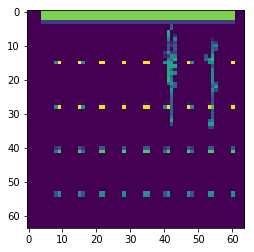

In [18]:
env = make_env()
plt.imshow(np.squeeze(env.reset()))

In [19]:
N_ACTIONS = env.action_space.n
OBS_SHAPE = env.observation_space.shape 

N_SIMULTANEOUS_GAMES = 16
SEQ_LENGTH = 10
N_EVAL_GAMES = 3

# DRQN

In [20]:
observation_layer = InputLayer((None,) + OBS_SHAPE)

conv1 = ConvLayer(observation_layer, num_filters=32, filter_size=5, stride=2, nonlinearity=elu)
conv2 = ConvLayer(conv1, num_filters=64, filter_size=5, stride=2, nonlinearity=elu)
conv3 = ConvLayer(conv2, num_filters=64, filter_size=3, stride=1, nonlinearity=elu)

prev_cell, prev_out = InputLayer((None, 256)), InputLayer((None, 256))
new_cell, new_out = LSTMCell(prev_cell, prev_out, conv3)

qvalues_layer = DenseLayer(new_out, num_units=N_ACTIONS, nonlinearity=None)
action_layer = EpsilonGreedyResolver(qvalues_layer)

weights = lasagne.layers.get_all_params(action_layer,trainable=True)

/usr/local/lib/python3.4/dist-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=2] One of the gate controllers (name='') has an input dimension of (None, 64, 11, 11) and will be flattened.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [21]:
target_net = TargetNetwork(qvalues_layer)
old_qvalues_layer = target_net.output_layers

In [22]:
agent = Agent(observation_layers=observation_layer,
             policy_estimators=[qvalues_layer, old_qvalues_layer],
             agent_states={new_cell: prev_cell, new_out: prev_out},
             action_layers=action_layer)

In [23]:
pool = EnvPool(agent, make_env, n_games=N_SIMULTANEOUS_GAMES, max_size=int(1e4)) 
replay = pool.experience_replay.sample_session_batch(128, replace=True)

_,_,_,_, (qvalues_seq, old_qvalues_seq) = agent.get_sessions(replay,
                                                             session_length=SEQ_LENGTH,
                                                             experience_replay=True)

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

loss = elwise_mse_loss.sum() / replay.is_alive.sum()

updates = lasagne.updates.adam(loss, weights)
train_step = theano.function([],loss,updates=updates)

[2017-04-17 15:53:44,925] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,001] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,057] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,108] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,151] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,198] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,255] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,307] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,356] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,408] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,459] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,501] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,550] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,590] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,633] Making new env: RoadRunner-v0
[2017-04-17 15:53:45,679] Making new env: RoadRunner-v0


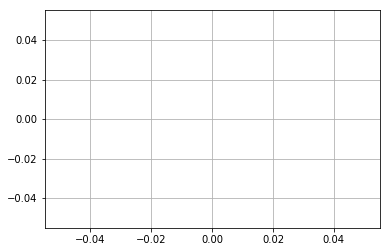

  0%|          | 2/5000 [01:44<81:11:33, 58.48s/it]


KeyboardInterrupt: 

In [24]:
N_EPOCH = 5000

epoch_counter = 0
rewards = {}
action_layer.epsilon.set_value(1.0)
for i in tqdm(range(N_EPOCH)):  
    for _ in range(10): pool.update(SEQ_LENGTH, append=True)
    loss = train_step()
    target_net.load_weights(0.1)
    
    current_epsilon = 0.01 + 0.99 * np.exp(-epoch_counter / 300.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
        
    if epoch_counter % 100 == 0:
        rewards[epoch_counter] = np.mean(pool.evaluate(record_video=False, 
                                                       n_games=N_EVAL_GAMES,
                                                       verbose=False))
        print("Current score(mean over %i) = %.3f"%(N_EVAL_GAMES, np.mean(rewards[epoch_counter])))
        clear_output(True)
        plt.plot(*zip(*sorted(rewards.items(),key=lambda t: t[0])))
        plt.grid()
        plt.show()
    
    epoch_counter  += 1

# A3C